# Cvičení 02 — Multilayer Perceptron (MLP), backpropagation a **LSE** (podrobně)

Tento notebook je **učebnicová** verze s delšími vysvětlivkami. Používáme **jen sigmoid** jako nelinearitu
(a **lineární výstup** u regrese) a jako ztrátu **LSE**:
\[
\mathcal{L}(\hat{y}, y) = \frac{1}{B}\sum_{i=1}^B \frac{1}{2}\,\|\hat{y}^{(i)} - y^{(i)}\|^2.
\]

## 0) Jupyter rychlostart (1–2 min)
- Spuštění buňky: **Shift+Enter**
- Přepnutí buňky na kód / markdown: **Y/M** (v command módu)
- Vložit buňku pod: **B**, smazat: **DD**

## 1) Knihovny a nastavení
Použijeme `numpy` a `matplotlib`. Pro dataset **Two Moons** se pokusíme použít `sklearn`, ale máme i NumPy fallback.

In [27]:
import numpy as np
import matplotlib.pyplot as plt

try:
    from sklearn.datasets import make_moons
    SKLEARN_OK = True
except Exception:
    SKLEARN_OK = False

np.set_printoptions(suppress=True, linewidth=120, precision=4)

## 2) Aktivace **sigmoid** a ztráta **LSE**
### Sigmoid
\[
\sigma(z) = \frac{1}{1 + e^{-z}}, \quad
\sigma'(z) = \sigma(z) (1 - \sigma(z)).
\]

### Least Squares Error (LSE)
Pro batch velikosti \(B\):
\[
\mathcal{L}(\hat{y}, y) = \frac{1}{B} \sum_{i=1}^B \frac{1}{2} \sum_k (\hat{y}_{ik} - y_{ik})^2.
\]
Derivace podle výstupu sítě:
\[
\frac{\partial \mathcal{L}}{\partial \hat{y}} = \frac{1}{B}\,(\hat{y} - y).
\]

In [28]:
class Sigmoid:
    def __call__(self, z):
        a = 1.0 / (1.0 + np.exp(-z))
        da_dz = a * (1.0 - a)
        return a, da_dz

class LSE:  # 1/2 * (y_hat - y)^2 averaged over batch
    def __call__(self, y_pred, y_true):
        diff = y_pred - y_true
        # průměr přes batch i výstupné dimenze, s faktorem 1/2
        loss = 0.5 * np.mean(np.sum(diff**2, axis=1))
        # dL/dy_pred = (1/B) * (y_pred - y_true)
        dL_dy = diff / y_pred.shape[0]
        return loss, dL_dy

## 3) Vrstvy MLP a **Xavier** inicializace
- **Xavier** pomáhá stabilizovat rozptyl signálů napříč vrstvami (vhodné pro sigmoid/tanh).
- **Dense** vrstva: dopředně \(z = xW + b\), aktivace \(a = \sigma(z)\) (nebo lineární bez aktivace).
- **Backprop**: z \(\partial L/\partial a\) dopočítáme \(\partial L/\partial z\), gradienty \(W, b\) a gradient do předchozí vrstvy.

In [29]:
class Dense:
    def __init__(self, in_dim, out_dim, activation):
        # Xavier-like init (pro sigmoid)
        limit = np.sqrt(1.0 / in_dim)
        self.W = np.random.uniform(-limit, limit, (in_dim, out_dim))
        self.b = np.zeros((1, out_dim))
        self.activation = activation
        # cache
        self.x = None; self.z = None; self.a = None; self.da_dz = None
        # grads
        self.dW = np.zeros_like(self.W); self.db = np.zeros_like(self.b)

    def forward(self, x):
        self.x = x
        self.z = x @ self.W + self.b
        if self.activation is None:
            self.a, self.da_dz = self.z, 1.0
        else:
            self.a, self.da_dz = self.activation(self.z)
        return self.a

    def backward(self, dL_da):
        dL_dz = dL_da * self.da_dz
        self.dW = self.x.T @ dL_dz / self.x.shape[0]
        self.db = np.mean(dL_dz, axis=0, keepdims=True)
        dL_dx = dL_dz @ self.W.T
        return dL_dx

    def step(self, lr):
        self.W -= lr * self.dW
        self.b -= lr * self.db

## 4) Model `MLP` a trénování s LSE
Trénink v každé epoše:
1. **Forward** \(\to \hat{y}\)
2. **LSE + derivace** \(\to \partial L/\partial \hat{y}\)
3. **Backward** (backprop přes vrstvy)
4. **Step** (aktualizace \(W,b\))

In [30]:
class MLP:
    def __init__(self, layers, loss):
        self.layers = layers
        self.loss = loss

    def forward(self, x):
        a = x
        for layer in self.layers:
            a = layer.forward(a)
        return a

    def backward(self, dL_dy):
        g = dL_dy
        for layer in reversed(self.layers):
            g = layer.backward(g)

    def step(self, lr):
        for layer in self.layers:
            layer.step(lr)

    def train(self, X, Y, lr=0.1, epochs=2000, batch_size=None, verbose=False):
        losses = []
        n = X.shape[0]
        for ep in range(epochs):
            if batch_size is None or batch_size >= n:
                idx = np.arange(n)
            else:
                idx = np.random.permutation(n)

            ep_loss = 0.0; batches = 0
            for start in range(0, n, batch_size or n):
                end = min(start + (batch_size or n), n)
                bidx = idx[start:end]
                xb, yb = X[bidx], Y[bidx]

                y_pred = self.forward(xb)
                loss, dL_dy = self.loss(y_pred, yb)
                self.backward(dL_dy)
                self.step(lr)

                ep_loss += loss; batches += 1

            losses.append(ep_loss / max(1, batches))
            if verbose and (ep+1) % max(1, epochs//10) == 0:
                print(f"epoch {ep+1}/{epochs} | loss={losses[-1]:.6f}")
        return np.array(losses)

## 5) Vizualizace — křivka ztráty a rozhodovací hranice
Graf ztráty ukáže, zda trénink **klesá**. Rozhodovací hranice v 2D intuitivně ukáže, co se síť naučila.

In [31]:
def plot_loss(losses, title="Průběh ztráty (LSE)"):
    plt.figure(); plt.plot(losses)
    plt.xlabel("Epoch"); plt.ylabel("Loss (LSE)"); plt.title(title); plt.show()

def plot_decision_boundary_2d(model, X, Y, title="Rozhodovací hranice"):
    x_min, x_max = X[:,0].min() - 0.5, X[:,0].max() + 0.5
    y_min, y_max = X[:,1].min() - 0.5, X[:,1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    with np.errstate(over='ignore'):
        zz = model.forward(grid)
    if zz.ndim == 2 and zz.shape[1] == 1:
        zz = (zz >= 0.5).astype(int)
    else:
        zz = np.argmax(zz, axis=1)
    zz = zz.reshape(xx.shape)
    plt.figure(); plt.contourf(xx, yy, zz, alpha=0.25, levels=2)
    plt.scatter(X[:,0], X[:,1], c=Y.ravel(), edgecolors="k")
    plt.title(title); plt.xlabel("x1"); plt.ylabel("x2"); plt.show()

# 6) Úloha A — **XOR** s LSE
XOR je nelineárně separovatelný. MLP (2–2–1) se sigmoid aktivací a LSE to zvládne.

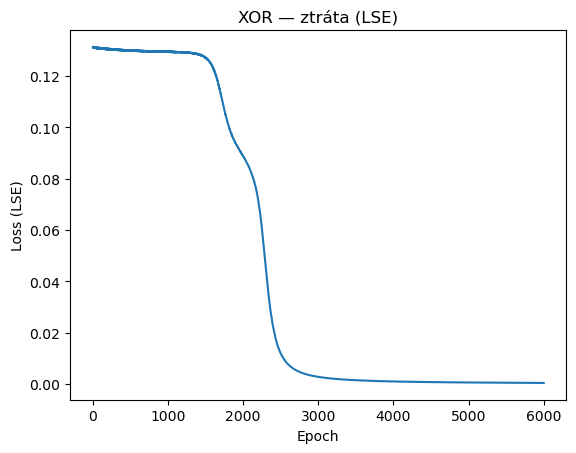

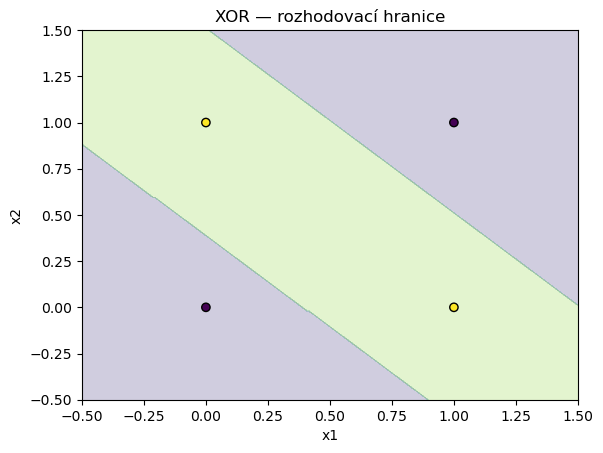

Predikce XOR: [0.025 0.973 0.973 0.034]


In [32]:
# XOR data
X_xor = np.array([[0,0],[0,1],[1,0],[1,1]], dtype=float)
Y_xor = np.array([[0],[1],[1],[0]], dtype=float)

np.random.seed(0)
xor_net = MLP(
    layers=[Dense(2, 2, Sigmoid()), Dense(2, 1, Sigmoid())],
    loss=LSE()
)
losses_xor = xor_net.train(X_xor, Y_xor, lr=0.5, epochs=6000, batch_size=1, verbose=False)
plot_loss(losses_xor, title="XOR — ztráta (LSE)")
plot_decision_boundary_2d(xor_net, X_xor, Y_xor, title="XOR — rozhodovací hranice")
print("Predikce XOR:", np.round(xor_net.forward(X_xor), 3).ravel())

## 7) Úloha B — **Two Moons** s LSE
Nelineární dvoutřídní klasifikace. Jedna skrytá vrstva se sigmoid vytvoří zakřivenou hranici.

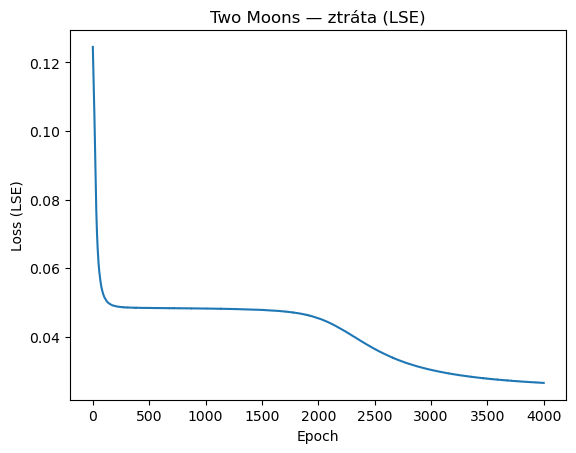

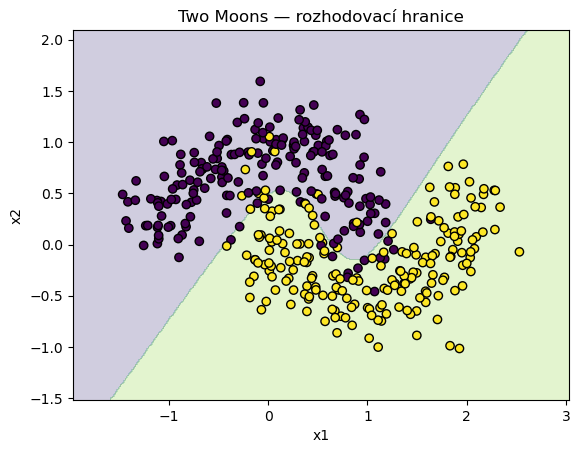

Přibližná trénovací přesnost: 92.2%


In [38]:
def make_moons_np(n_samples=200, noise=0.1, seed=42):
    rng = np.random.default_rng(seed)
    n = n_samples // 2
    t1 = rng.uniform(0, np.pi, n)
    x1 = np.c_[np.cos(t1), np.sin(t1)] + rng.normal(scale=noise, size=(n,2))
    t2 = rng.uniform(0, np.pi, n)
    x2 = np.c_[1 - np.cos(t2), 1 - np.sin(t2) - 0.5] + rng.normal(scale=noise, size=(n,2))
    X = np.vstack([x1, x2]); y = np.vstack([np.zeros((n,1)), np.ones((n,1))])
    idx = rng.permutation(X.shape[0]); return X[idx], y[idx]

if SKLEARN_OK:
    X_moons, y_moons = make_moons(n_samples=400, noise=0.25, random_state=0)
    y_moons = y_moons.reshape(-1,1).astype(float)
else:
    X_moons, y_moons = make_moons_np(n_samples=400, noise=0.25, seed=0)

np.random.seed(1)
moons_net = MLP(layers=[Dense(2, 12, Sigmoid()), Dense(12, 1, Sigmoid())], loss=LSE())
losses_moons = moons_net.train(X_moons, y_moons, lr=0.2, epochs=4000, batch_size=5, verbose=False)
plot_loss(losses_moons, title="Two Moons — ztráta (LSE)")
plot_decision_boundary_2d(moons_net, X_moons, y_moons, title="Two Moons — rozhodovací hranice")
pred = (moons_net.forward(X_moons) >= 0.5).astype(int)
acc = (pred == y_moons).mean()*100
print(f"Přibližná trénovací přesnost: {acc:.1f}%")

## 8) Úloha C — **1D regrese** (sinus) s LSE
Regrese má **lineární výstup**. Síť aproximuje \(\sin(2\pi x)\) se šumem pomocí LSE.

In [ ]:
rng = np.random.default_rng(0)
Xr = rng.uniform(-1.0, 1.0, size=(200,1))
Yr = np.sin(2*np.pi*Xr) + rng.normal(scale=0.1, size=(200,1))

np.random.seed(2)
reg_net = MLP(layers=[Dense(1, 32, Sigmoid()), Dense(32, 32, Sigmoid()), Dense(32, 1, None)], loss=LSE())
losses_reg = reg_net.train(Xr, Yr, lr=0.1, epochs=6000, batch_size=1, verbose=False)
plot_loss(losses_reg, title="Regrese — ztráta (LSE)")

xs = np.linspace(-1.2, 1.2, 400).reshape(-1,1)
ys = reg_net.forward(xs)
plt.figure()
plt.scatter(Xr, Yr, s=10, alpha=0.6, label="data")
plt.plot(xs, np.sin(2*np.pi*xs), linestyle="--", label="sin(2πx) — ground truth")
plt.plot(xs, ys, label="MLP predikce")
plt.legend(); plt.title("Regrese: sin(2πx)"); plt.show()